# **<center>Asking Questions and Analyzing Section</center>**

## **_00. Import necessary libraries:_**

In [35]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from mlxtend.frequent_patterns import apriori, association_rules

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

## **_01. Asking meaningfull questions:_**

### **_01.1. Question number 1: `What is the distribution of customer on avarage spending money and most favourite item by demographics?`_**

- **Nội dung**: Phân bố khách hàng theo độ tuổi và giới tính, số tiền mua trung bình theo nhóm tuổi hoặc giới tính và các loại sản phẩm phổ biến nhất ở các nhóm tuổi hoặc giới tính khác nhau.
- **Mục đích**: Chúng ta sẽ hiểu hơn về khách hàng, một số yếu tố như độ tuổi, giới tính và loại sản phẩm có thể tác động mạnh tới doanh thu công ty Fashion Campus.
- **Phân tích**:
    - Phân tích phân bố của khách hàng theo độ tuổi và giới tính, từ đó chúng ta so sánh độ lệch trong biểu đồ histogram và chênh lệch giữa các giới tính
    - Xác định số tiền mua trung bình theo nhóm tuổi hoặc giới tính, tại trong dữ liệu của chúng ta sẽ có nhiều lứa tuổi, vì vậy việc phân tích thành các cụm là rất cần thiết.
    - Xác định những sản phẩm nào được mua phổ biến theo từng nhóm tuổi


### **_01.2. Question number 2: `Which products are more inclined to be bought together?`_**

- **Nội dung**: Phân tích những sản phẩm hoặc nhóm sản phẩm thường xuyên mua cùng nhau bằng thuật toán `Apriori` từ đó đề xuất các sản phẩm bổ sung dựa trên lịch sử mua hàng của khách hàng.
- **Mục đích**: Tối ưu hóa chiến dịch tiếp thị, doanh nghiệp có thể xác định những chiến dịch tiếp thị hiệu quả nhất bằng cách tìm ra những quy luật kết hợp giữa các sản phẩm hoặc dịch vụ mà khách hàng thường mua. Điều này giúp tối ưu hóa ngân sách tiếp thị và tạo ra chiến dịch hiệu quả hơn.
- **Phân tích**:
    - Đầu tiên chúng ta cần hiểu một số thông tin về thuật toán Apriori.
    - Kiểm tra các sản phẩm được mua với số lượng như thế nào.
    - Sử dụng thuật toán Apriori cùng với các chỉ số như min_suport, min_threshold để phân tích tính liên kết các sản phẩm trong Fashion Campus
    - Trực quan hóa các liên kết từ đó đánh giá được mối quan hệ giữa các sản phẩm.

### **_01.3. Question number 3_**

### **_01.4. Question number 4: `How do monthly or weekly sales trends manifest in the total sales figures? Are there forecasts for future sales?`_**

- **Nội dung**: Chúng ta sẽ xác định xu hướng hàng tháng hoặc hàng tuần trong tổng doanh số bán hàng, từ đó dự đoán ra doanh số bán hàng qua mô hình Arima. Ngoài ra chúng ta sẽ xem xét ngành hàng nào được bán chạy nhất theo thời gian.
- **Mục đích**: Dự đoán được doanh thu của công ty từ đó có thể đưa ra các chiến lược bán hàng hợp lý
   => ta nhận thấy lượng toltal sales tăng dần theo năm, tuy nhiên đến giữa khoảng 2022 có dấu hiệu đi xuống, vì thế chúng tôi tập trung đẩy mạnh vào marketing nhằm nâng cao doanh thu mua hàng
- **Phân tích**:
    - Xử lý những giao dịch thành công hoặc thất bại trong `payment_status`
    - Xác định khoảng thời gian nào khách hàng mua hàng nhiều nhất
    - Phân tích doanh thu theo khoảng thời gian như ngày, tuần, tháng.
    - Sử dụng mô hình Arima để dự đoán doanh số 
    - Phân tích xu hướng lợi nhuận theo thời gian của từng ngành hàng

## **_02. Input Data and Pre-processing Data:_**

Phần code này thực hiện:
- Thực hiện lại tiền xử lý cho ba bộ dữ liệu `product`, `customer`, `transaction`

**Đọc dữ liệu cho transaction_new**

In [36]:
# Đọc dữ liệu transaction
df_transaction = pd.read_csv('Data/transaction_new.csv')
df_transaction.head(2)

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price
0,2018-07-29T15:22:01.458193Z,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03T05:07:24.812676Z,-8.227893,111.969107,199832,54728,1,191247
1,2018-07-30T12:40:22.365620Z,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,NaN,10000,2018-08-03T01:29:03.415705Z,3.013470,107.802514,155526,16193,1,145526


**Tiền xử lí cho customer**

In [37]:
df_customer = pd.read_csv("Data/customer.csv")
# Chuyển dữ liệu thời gian về đúng kiểu dữ liệu
df_customer['first_join_date'] = pd.to_datetime(df_customer['first_join_date'])
df_customer['birthdate'] = pd.to_datetime(df_customer['birthdate'])

df_customer.head(2)

,customer_id,first_name,last_name,username,email,gender,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date
0,2870,Lala,Maryati,671a0865-ac4e-4dc4-9c4f-c286a1176f7e,671a0865_ac4e_4dc4_9c4f_c286a1176f7e@startupca...,F,1996-06-14,iOS,c9c0de76-0a6c-4ac2-843f-65264ab9fe63,iPhone; CPU iPhone OS 14_2_1 like Mac OS X,-1.043345,101.360523,Sumatera Barat,Indonesia,2019-07-21
1,8193,Maimunah,Laksmiwati,83be2ba7-8133-48a4-bbcb-b46a2762473f,83be2ba7_8133_48a4_bbcb_b46a2762473f@zakyfound...,F,1993-08-16,Android,fb331c3d-f42e-40fe-afe2-b4b73a8a6e25,Android 2.2.1,-6.212489,106.818850,Jakarta Raya,Indonesia,2017-07-16


**Tiền xử lí cho product**

In [38]:
df_product = pd.read_csv("Data/product.csv")
# rename: Đổi tên cột
df_product = df_product.rename(columns = {'id' : 'product_id'})
df_product.head(2)

,product_id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans


## **_03. Analyzing Data to Answer each Question:_**

### **_03.1. Question number 1: `What is the distribution of customer on avarage spending money and most favourite item by demographics?`_**

#### **_03.1.1. Pre-process Data:_**

  - Phân bố khách hàng theo độ tuổi và giới tính.
  - Số tiền mua trung bình theo nhóm tuổi hoặc giới tính.
  - Các loại sản phẩm phổ biến nhất ở các nhóm tuổi hoặc giới tính khác nhau.

**Tạo cột mới**

Tạo cột `Age` cho df_customer: Hiện tại chúng ta đã có cột `birthdate` tức ngày sinh của khách hàng, vì vậy chúng ta sẽ tính tuổi bằng cách lấy thời điểm hiện tại trừ cho ngày sinh của khách hàng.

In [39]:
from datetime import datetime

df_customer['Age'] = ((datetime.now() - df_customer['birthdate']).dt.days / 365.25).round().astype(np.int64)

**Biểu đồ phân bố khách hàng theo độ tuổi và giới tính.**

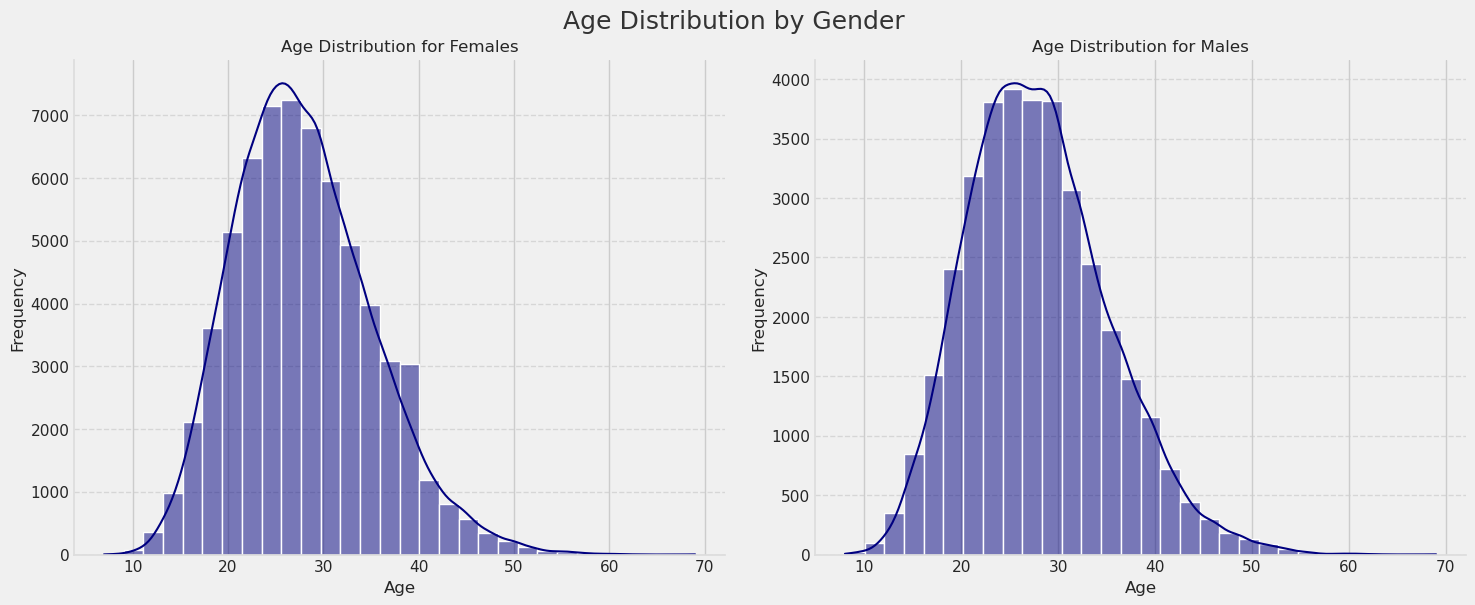

In [40]:
# Set a visually pleasing style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot for Gender F
sns.histplot(data=df_customer[df_customer['gender'] == 'F'], x="Age", color='navy', kde=True, ax=axes[0], bins=30)
axes[0].set(title='Age Distribution for Females', xlabel='Age', ylabel='Frequency')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for Gender M
sns.histplot(data=df_customer[df_customer['gender'] == 'M'], x="Age", color='navy', kde=True, ax=axes[1], bins=30)
axes[1].set(title='Age Distribution for Males', xlabel='Age', ylabel='Frequency')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Customize background color
fig.set_facecolor('#f0f0f0')
axes[0].set_facecolor('#f0f0f0')
axes[1].set_facecolor('#f0f0f0')

# Adjust layout
plt.tight_layout()

# Add a title for the entire figure
plt.suptitle('Age Distribution by Gender', fontsize=18, y=1.02, color='#333333')

# Remove spines
sns.despine()

# Add a subtle gray border to the plots
for ax in axes:
    ax.spines['top'].set_color('#dddddd')
    ax.spines['right'].set_color('#dddddd')
    ax.spines['bottom'].set_color('#dddddd')
    ax.spines['left'].set_color('#dddddd')

# Customize tick parameters
for ax in axes:
    ax.tick_params(axis='both', which='both', length=0)

# Show the plots
plt.show()

- Chúng ta có thể thấy rằng qua biểu đồ histogram thì giới tính Nam và Nữ không có sự khác nhau nhiều.
- Độ tuổi từ 20 - 35 là khoảng thời gian mua hàng nhiều nhất của cả hai giới tính
- Cả hai biểu đồ đều có dạng phân phối chuẩn

#### **_03.1.2. The avarage money spending base on Age and Gender_**

- Dựa vào bảng dữ liệu `transaction` chúng ta thấy số tiền mua hàng được tính dựa vào các thông số như `quantity`, `item_price`, `shipment_fee` và `promo_amount`. Dựa vào những thông số đó sẽ cho ra kết quả `total_amount` thể hiện tổng số tiền mua hàng của mỗi khách hàng
- Mỗi khách hàng có thể mua nhiều sản phẩm, vì vậy chúng ta sẽ thực hiện gộp chúng lại

In [41]:
df_amount_cus = df_transaction.groupby('customer_id', as_index =False)['total_amount'].sum()
df_amount_cus = df_amount_cus.groupby(['customer_id'])['total_amount'].sum().reset_index()

df_amount_cus_trans = df_customer[['customer_id' , 'gender' , 'Age']].merge(df_amount_cus , how = 'left' , on = 'customer_id')
df_amount_cus_trans


,customer_id,gender,Age,total_amount
0,2870,F,28,NaN
1,8193,F,30,NaN
2,7279,M,35,98661780.0
3,88813,M,33,NaN
4,82542,M,23,115702.0
...,...,...,...,...
99995,34743,M,23,26453036.0
99996,72065,M,26,59084450.0
99997,32818,F,31,296679636.0
99998,75597,M,23,NaN


- Để giải quyết bài toán số tiền trung bình theo nhóm tuổi hoặc giới tính chúng ta cần ghép hai bộ dữ liệu `customer` và `transaction`

**Biểu đồ thể hiện số tiền trung bình mà các nhóm tuổi mua hàng**

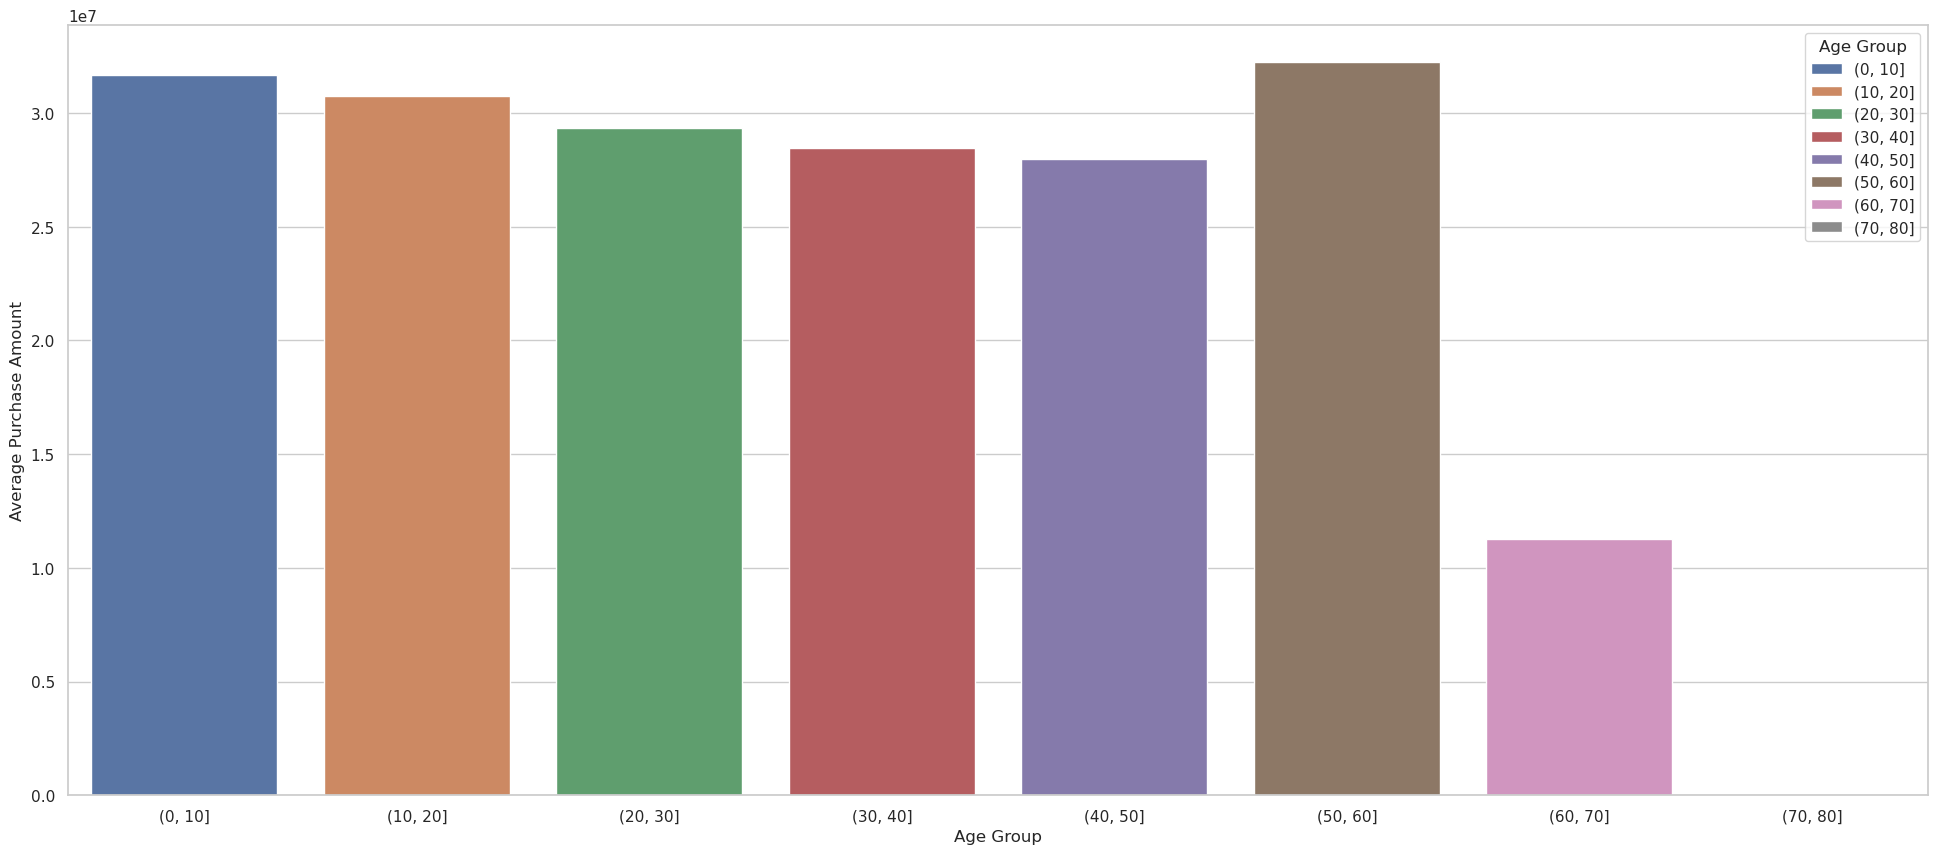

In [42]:
plt.figure(figsize=(24, 10))
age_bins = [0,10,20, 30, 40, 50, 60, 70, 80]
df_amount_cus_trans['Age Group'] = pd.cut(df_amount_cus_trans['Age'], bins=age_bins)
avg_purchase_by_age = df_amount_cus_trans.groupby(['Age Group'])['total_amount'].mean().reset_index()
sns.barplot(avg_purchase_by_age, x="Age Group", y="total_amount" , hue="Age Group")
plt.ylabel('Average Purchase Amount')
plt.show()

<Figure size 2400x1000 with 0 Axes>

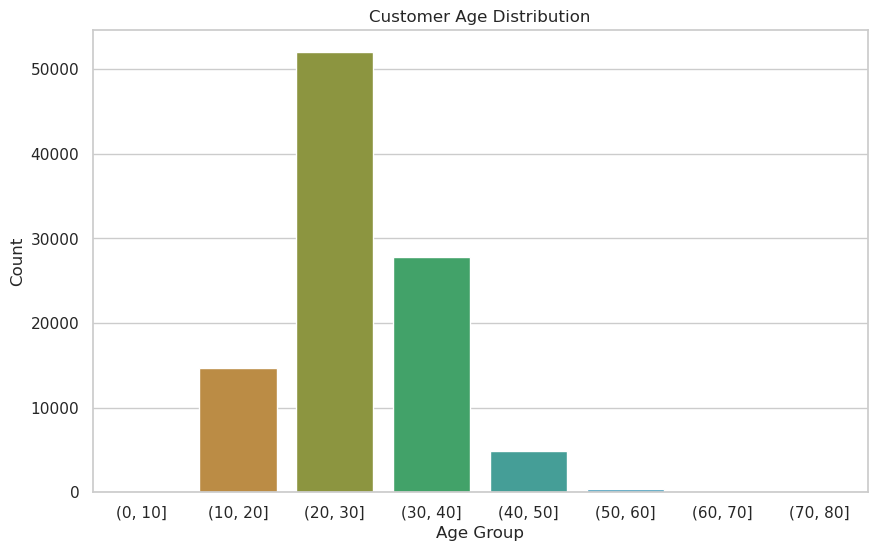

In [43]:
plt.figure(figsize=(24, 10))

age_labels = ['(0, 10]', '(10, 20]', '(20, 30]', '(30, 40]', '(40, 50]', '(50, 60]', '(60, 70]' , '(70, 80]']

plt.figure(figsize=(10, 6))
sns.countplot(data=df_amount_cus_trans, x='Age Group', order=age_labels , palette='husl')
plt.title('Customer Age Distribution')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

### **_03.2. Question number 2: `Which products are more inclined to be bought together?`_**

#### **_03.2.1. Pre-process Data:_**

**Merge dữ liệu**

In [44]:
# merge dữ liệu 3 bảng customer, product, transaction
df_transaction_cus = df_transaction.merge(df_customer , how = 'left' , on = 'customer_id')
df_transaction_cus_prod = df_transaction_cus.merge(df_product , how = 'left' , on = 'product_id')

df_transaction_cus_prod.head(2)

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price,first_name,last_name,username,email,gender_x,birthdate,device_type,device_id,device_version,home_location_lat,home_location_long,home_location,home_country,first_join_date,Age,gender_y,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,2018-07-29T15:22:01.458193Z,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03T05:07:24.812676Z,-8.227893,111.969107,199832,54728,1,191247,Titin,Pratiwi,498c2a5e-bafe-42cc-94f9-2832ac5e1f6b,498c2a5e_bafe_42cc_94f9_2832ac5e1f6b@startupca...,F,2000-08-20,Android,d1b5c84a-7718-4b7b-b5a2-cfa23d7dd836,Android 8.0.0,-6.122897,106.876500,Jakarta Raya,Indonesia,2018-07-28,23,Men,Footwear,Shoes,Casual Shoes,Black,Summer,2012.0,Casual,Vans Men Black Shoes
1,2018-07-30T12:40:22.365620Z,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,NaN,10000,2018-08-03T01:29:03.415705Z,3.013470,107.802514,155526,16193,1,145526,Uchita,Hassanah,5009ab96-84ff-44ef-98b0-c1b492658c29,5009ab96_84ff_44ef_98b0_c1b492658c29@startupca...,F,1996-03-15,Android,cec6d891-746b-453e-a330-0f6d024929f6,Android 3.2.6,-3.602334,120.363824,Sulawesi Selatan,Indonesia,2018-07-28,28,Men,Apparel,Topwear,Sweaters,Green,Fall,2011.0,Casual,Puma Men Knitted Vest Green Sweater


#### **_03.2.2. Cross Selling:_**

- Bán chéo là khả năng bán nhiều sản phẩm hơn cho khách hàng bằng cách phân tích xu hướng mua sắm của khách hàng cũng như các xu hướng và mô hình mua sắm chung có điểm chung với mô hình mua sắm của khách hàng. Thường xuyên hơn không, những sản phẩm được đề xuất này sẽ rất hấp dẫn. Nhà bán lẻ thường sẽ cung cấp cho bạn một gói sản phẩm với một số ưu đãi hấp dẫn và rất có thể chúng ta sẽ mua các sản phẩm đi kèm thay vì chỉ mua sản phẩm ban đầu.

- Vì vậy, chúng ta sẽ nghiên cứu các giao dịch của khách hàng và tìm ra những bổ sung tiềm năng cho nhu cầu ban đầu của khách hàng và đưa ra gợi ý cho khách hàng với hy vọng và ý định rằng họ mua chúng sẽ mang lại lợi ích cho cả khách hàng cũng như sàn thương mại điện tử.

- Trong phần này, chúng ta sẽ khám phá việc khai thác association rule-mining, một kỹ thuật mạnh mẽ có thể được sử dụng để bán chéo, sau đó chúng ta áp dụng khái niệm phân tích giỏ hàng thị trường cho tập dữ liệu giao dịch bán lẻ của mình.



#### **_03.2.3. Algorithms:_**

- Một số thuật toán nổi tiếng là Apriori, Eclat và FP-Growth, nhưng chúng chỉ thực hiện được một nửa công việc vì chúng là các thuật toán để khai thác các tập phổ biến. Một bước khác cần được thực hiện sau đó để tạo quy tắc từ các tập phổ biến được tìm thấy trong cơ sở dữ liệu.

- Nút thắt lớn nhất trong bất kỳ thuật toán khai thác luật kết hợp nào là việc tạo ra các tập phổ biến. Nếu tập dữ liệu giao dịch có k sản phẩm duy nhất thì có khả năng chúng ta có 2^k tập mục có thể.

**Apriori**

Trong phần này chúng ta sử dụng phương pháp Apriori vì vậy chúng ta sẽ nói sơ qua Apriori sẽ làm những gì.

Apriori sử dụng chiến lược tìm kiếm theo chiều rộng để tính độ hỗ trợ của các tập mục và sử dụng hàm tạo ứng cử viên để khai thác thuộc tính đóng xuống của hỗ trợ. Vì vậy, trước tiên thuật toán sẽ tạo các tập mục này và sau đó tiến hành tìm các tập phổ biến. Đối với khoảng 100 sản phẩm duy nhất, số lượng tập mục có thể có là rất lớn và cho thấy thuật toán Apriori cực kỳ tốn kém về mặt tính toán.


#### **_03.2.4. Implement:_**

In [45]:
df_transaction_cus_prod['masterCategory'].unique()

array(['Footwear', 'Apparel', 'Accessories', 'Personal Care',
       'Free Items', 'Sporting Goods', 'Home'], dtype=object)

**Số lượng sản phẩm trung bình được mua trong một giao dịch.**

In [46]:
df_trans_cate = df_transaction.merge(df_product[['product_id' , 'masterCategory']] , how = 'left' , on = 'product_id')

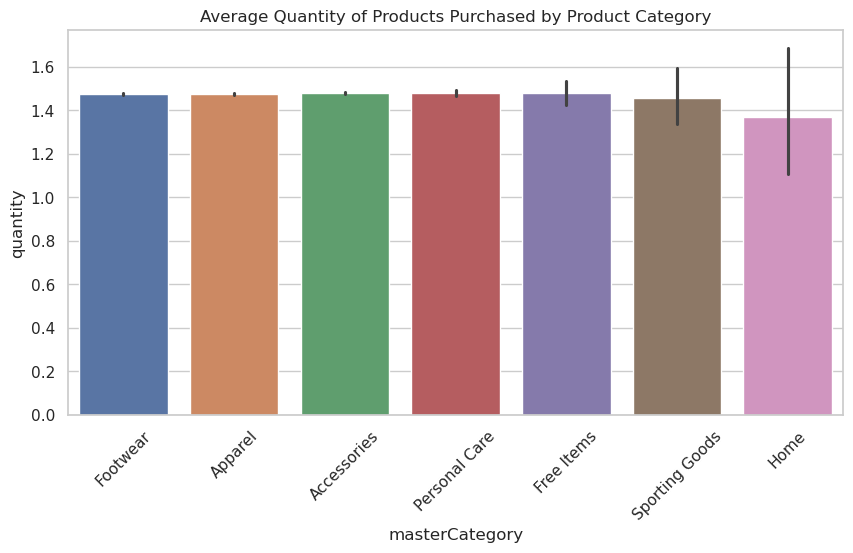

In [47]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df_trans_cate, x='masterCategory', y='quantity', hue="masterCategory")
plt.title('Average Quantity of Products Purchased by Product Category')
plt.xticks(rotation=45)
plt.show()

- Chúng ta nhận thấy rằng có 6 `masterCategory` tức danh mục sản phẩm chính được bán ra trong sàn thương mại điện tử bao gồm: 'Footwear', 'Apparel', 'Accessories', 'Personal Care', 'Free Items', 'Sporting Goods', 'Home'.
- Các danh mục sản phẩm chính `masterCategory` được bán ra đồng đều. Vì vậy khi sử dụng thuật toán apriori chúng ta sẽ đảm bảo dữ liệu cân bằng.

- Sử dụng thuật toán Apriori để xác định những sản phẩm thường xuyên mua cùng nhau và đề xuất các loại sản phẩm phù hợp theo dữ liệu quá khứ

In [48]:
basket = df_transaction_cus_prod.groupby(['customer_id', 'masterCategory'])['quantity'].sum().unstack().fillna(0)
basket[basket > 0] = 1
basket

masterCategory,Accessories,Apparel,Footwear,Free Items,Home,Personal Care,Sporting Goods
customer_id,,,,,,,
3,1.0,1.0,1.0,0.0,0.0,1.0,0.0
8,0.0,1.0,1.0,1.0,0.0,1.0,0.0
9,1.0,1.0,0.0,0.0,0.0,1.0,0.0
11,1.0,0.0,0.0,0.0,0.0,0.0,0.0
15,1.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
99992,1.0,1.0,1.0,0.0,0.0,1.0,0.0
99995,1.0,1.0,1.0,0.0,0.0,1.0,1.0
99997,1.0,0.0,0.0,0.0,0.0,0.0,0.0


- min_support (Minimum Support): Tham số min_support đề cập đến độ Support tối thiểu cần thiết để một tập mục được coi là frequent. Support là thước đo tần suất một tập hợp mục cụ thể xuất hiện trong tập dữ liệu. Giá trị min_support cao hơn sẽ dẫn đến ít frequent itemsets, có khả năng bỏ lỡ các liên kết thú vị nhưng ít thường xuyên hơn. Ngược lại, min_support thấp hơn có thể bao gồm quá nhiều tập mục, làm tăng độ phức tạp tính toán và có thể bao gồm các liên kết ít ý nghĩa hơn.

- min_threshold (Minimum Threshold): Thuật ngữ min_threshold thường được sử dụng trong bối cảnh độ tin cậy hoặc độ nâng của các luật kết hợp. Trong hầu hết các hoạt động triển khai, tham số này đặt độ tin cậy tối thiểu hoặc giá trị nâng cao để một quy tắc kết hợp được coi là quan trọng.

**Chúng ta chọn min_support = 0.05, min_threshold = 1**

In [49]:
# Chuyển đổi dữ liệu thành định dạng được mã hóa one-hot
basket = df_transaction_cus_prod.groupby(['customer_id', 'masterCategory'])['quantity'].sum().unstack().fillna(0)

# Chuyển đổi giá trị số lượng sang nhị phân (1 nếu đã mua, 0 nếu không)
basket[basket > 0] = 1

# Thực hiện thuật toán Apriori để tìm tập mục thường xuyên
frequent_itemsets = apriori(basket, min_support=0.05, use_colnames=True)

# Tạo quy tắc kết hợp
association_rules_transaction_cus = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Lọc và sắp xếp các quy tắc cho đề xuất
recommended_rules = association_rules_transaction_cus[association_rules_transaction_cus['lift'] > 1.0].sort_values(by='lift', ascending=False)

# Hiển thị các quy tắc được đề xuất
recommended_rules[['antecedents', 'consequents', 'support', 'lift']]

,antecedents,consequents,support,lift
55,"(Personal Care, Apparel)","(Accessories, Footwear)",0.387279,1.470263
54,"(Accessories, Footwear)","(Personal Care, Apparel)",0.387279,1.470263
50,"(Accessories, Apparel, Footwear)",(Personal Care),0.387279,1.459882
59,(Personal Care),"(Accessories, Apparel, Footwear)",0.387279,1.459882
57,"(Apparel, Footwear)","(Accessories, Personal Care)",0.387279,1.421896
...,...,...,...,...
12,(Personal Care),(Apparel),0.433724,1.096979
8,(Apparel),(Footwear),0.654058,1.042902
9,(Footwear),(Apparel),0.654058,1.042902
1,(Apparel),(Accessories),0.680544,1.033148


**Trực quan hóa các liên kết**

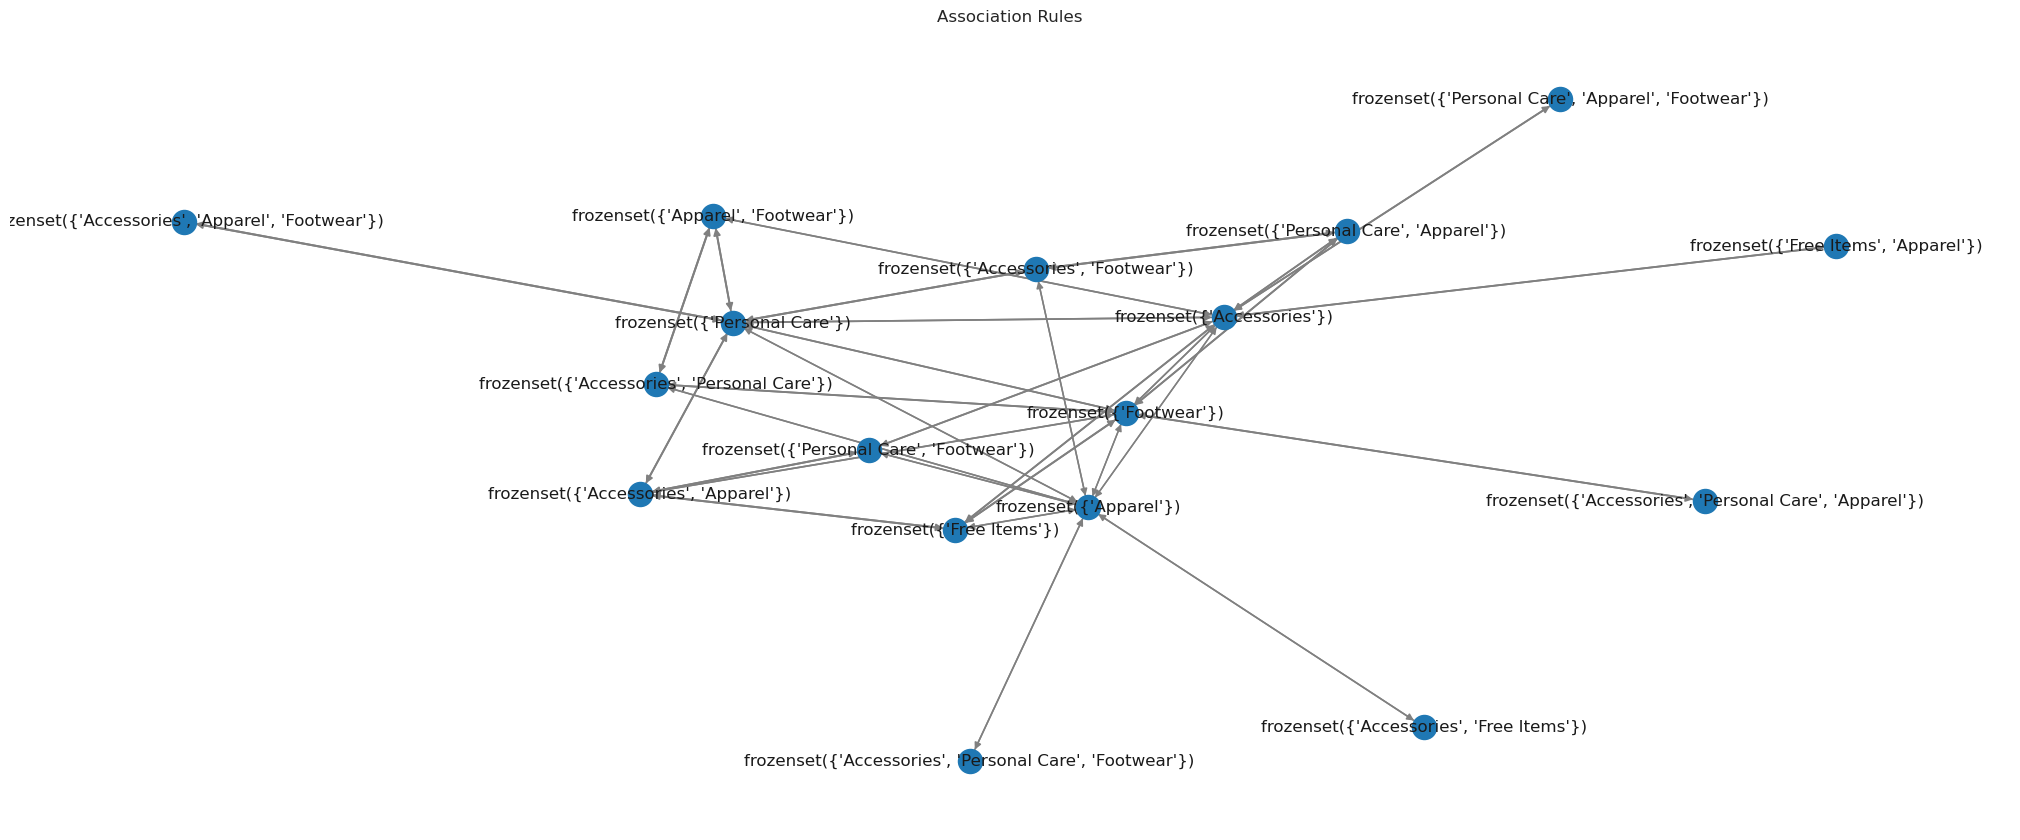

In [50]:
# Network Graph Visualization
G = nx.DiGraph()
plt.figure(figsize=(20, 8))
for _, row in recommended_rules.iterrows():
    G.add_edge(str(row['antecedents']), str(row['consequents']), weight=row['lift'])

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, edge_color='gray', width=[G[u][v]['weight'] for u,v in G.edges()])
plt.title("Association Rules")
plt.show()

**Nhận xét**
- Dựa vào các luật kết hợp trên chúng ta có thể thấy một số trường hợp như sau:
    - Khi khách hàng mua `Personal Care` và `Apparel` thì khi đó khách hàng cũng sẽ mua `Footwear` và `Accessories`
    - Hoặc với bộ itemset chứa 3 hạng mục thì, khách hàng mua `Footwear, Apparel, Accessories` khi đó khách hàng sẽ mua thêm `Personal Care`
    - Hầu hết các bộ itemset chứa 1 hạng mục là phần nhiều

### **_03.3. Question number 3_**

### **_03.4. Question number 4: `How do monthly or weekly sales trends manifest in the total sales figures? Are there forecasts for future sales?`_**

  > Mục tiêu: Dự đoán được doanh thu của công ty từ đó có thể đưa ra các chiến lược bán hàng hợp lý
   => ta nhận thấy lượng toltal sales tăng dần theo năm, tuy nhiên đến giữa khoảng 2022 có dấu hiệu đi xuống, vì thế chúng tôi tập trung đẩy mạnh vào marketing nhằm nâng cao doanh thu mua hàng
  
1. Tập trung vào Digital Marketing:
Nâng cấp trang web và di động: Tối ưu hóa trải nghiệm người dùng để tăng tỷ lệ chuyển đổi.
Sử dụng nền tảng mạng xã hội: Tạo nội dung hấp dẫn và tương tác với khách hàng thông qua các kênh như Instagram, Facebook, TikTok.
Email Marketing: Xây dựng danh sách email và triển khai chiến lược gửi email hiệu quả với thông tin sản phẩm, khuyến mãi, và sự kiện.
2. Kế hoạch Content Marketing:
Blog và Video: Tạo nội dung hữu ích về thời trang, xu hướng mới, cách phối đồ, và hướng dẫn thời trang.
Collaboration và Influencer Marketing: Hợp tác với các influencer hoặc blogger thời trang để quảng bá sản phẩm của bạn.
3. Phát triển Chương trình Thưởng và Khuyến mãi:
Loyalty Program: Tạo chương trình thưởng để khích lệ khách hàng quay lại mua hàng và tăng tính trung thành.
Khuyến mãi đặc biệt: Áp dụng chiến lược giảm giá, quà tặng hoặc ưu đãi cho các sự kiện đặc biệt như Black Friday, Giáng sinh, hay sinh nhật công ty

In [51]:
df_transaction = pd.read_csv('Data/transaction_new.csv')
df_transaction_trend = df_transaction.copy()

#### **_03.4.1. Frequency of shopping days to determine peak shopping times (e.g., weekends, holidays, end of the month)_**


- Chúng ta có thể thấy rằng một số đơn đặt hàng trong cột `payment_status` có thể `Success` hoặc `Failed`, vì vậy chúng ta sẽ không xét tới những đơn đặt hàng bị hủy bỏ mà chỉ tập trung vào những đơn đặt hàng thành công

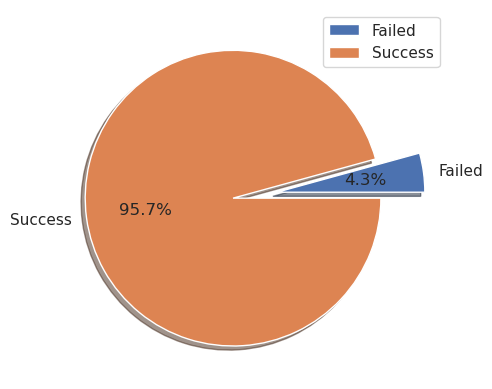

In [52]:
explodeSize = [0.1, 0.2]
payStatus = df_transaction.groupby(['payment_status'])['payment_status'].count()
plt.pie(payStatus, labels = ['Failed', 'Success'], shadow = True, autopct='%1.1f%%', explode = explodeSize)
plt.legend()

Tỉ lệ Failed chiếm 4.3%, vì vậy chúng ta sẽ loại bỏ những giao dịch này.

In [53]:
df_transaction = df_transaction[df_transaction['payment_status'] == 'Success']

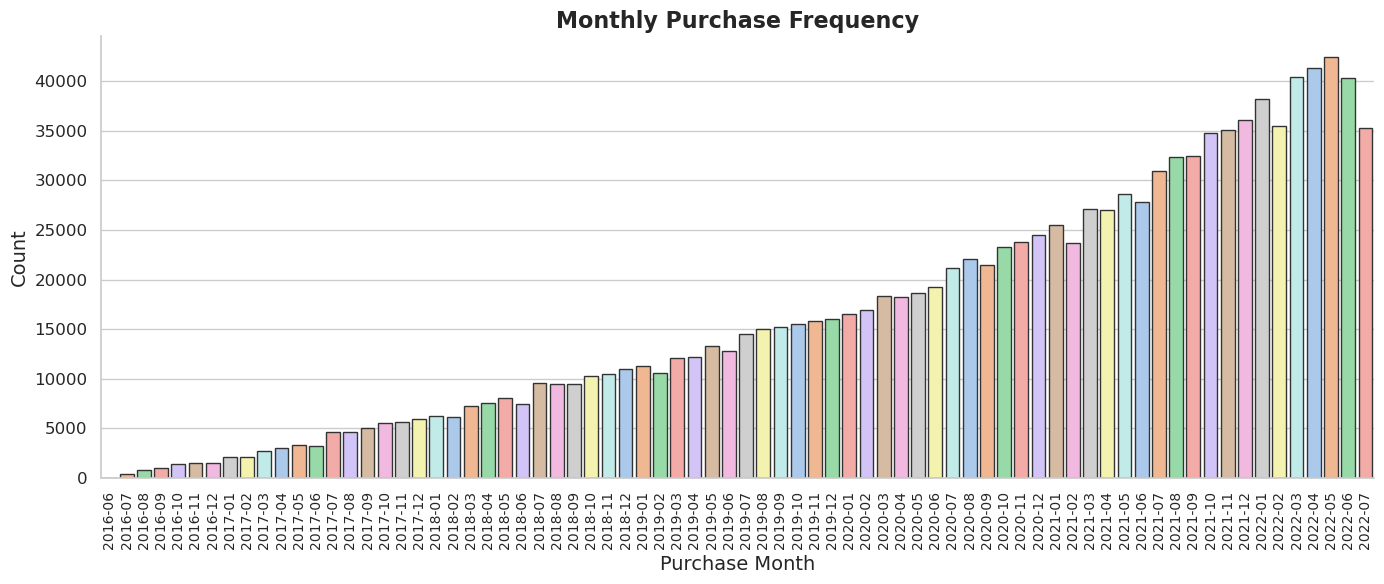

In [54]:
fig, ax = plt.subplots(figsize=(14, 6))

# Convert 'created_at' to datetime
df_transaction['created_at'] = pd.to_datetime(df_transaction['created_at'])

# Remove timezone information if present
df_transaction['created_at'] = df_transaction['created_at'].dt.tz_localize(None)

# Extract 'Purchase Month'
df_transaction['Purchase Month'] = df_transaction['created_at'].dt.to_period('M')

# Plotting with the default Seaborn palette
sns.countplot(data=df_transaction, x='Purchase Month', 
        order=sorted(df_transaction['Purchase Month'].unique()), edgecolor='0.2', palette='pastel', legend=False)

# Customize the plot
ax.set_title('Monthly Purchase Frequency', fontsize=16, weight='bold')
ax.set_xlabel('Purchase Month', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.tick_params(axis='x', rotation=90, labelsize=10)
ax.tick_params(axis='y', labelsize=12)
sns.despine()

# Display the plot
plt.tight_layout()
plt.show()

##### Nhận xét
- Dường như sàn thương mại điện tử phát triển rất tốt, số lượng giao dịch mua hàng ngày càng tăng theo thời gian từ năm 2016 tới năm 2022.
- Dường như trong giai đoạn dịch covid-19 đã làm cho lượng giao dịch tăng lên rất nhiều.

#### **_03.4.2. Which season will customers buy the most?_**

Khách hàng sẽ mua sắm theo mùa, có một số mùa thường như cầu mua sắm sẽ nhiều hơn như mùa hè hoặc mùa đông. Vì vậy chúng ta sẽ xem rằng các mùa có sự khác nhau về nhu cầu mua sắm hay không

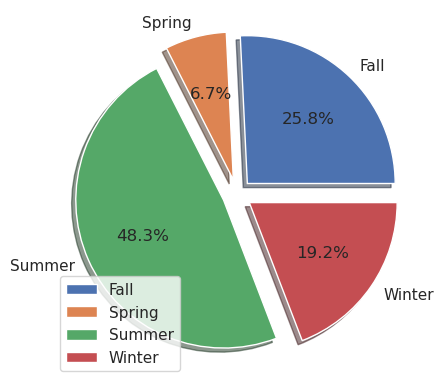

In [55]:
season = df_product.groupby(['season'])['season'].count()
explodeSize = [0.1, 0.1, 0.1, 0.1]
plt.pie(season, labels = ['Fall', 'Spring', 'Summer', 'Winter'], shadow = True, autopct='%1.1f%%', explode = explodeSize)
plt.legend()

- Mùa Hè là thời điểm mà doanh thu của Fashion Campus tăng mạnh nhất, chiếm 48.3%
- Mùa Xuân là thời điểm doanh thu thấp nhất chỉ với 6.7%

#### **_03.4.3. Analyzing revenue trends over time_**

**1. Monthly trends in total sales volume**

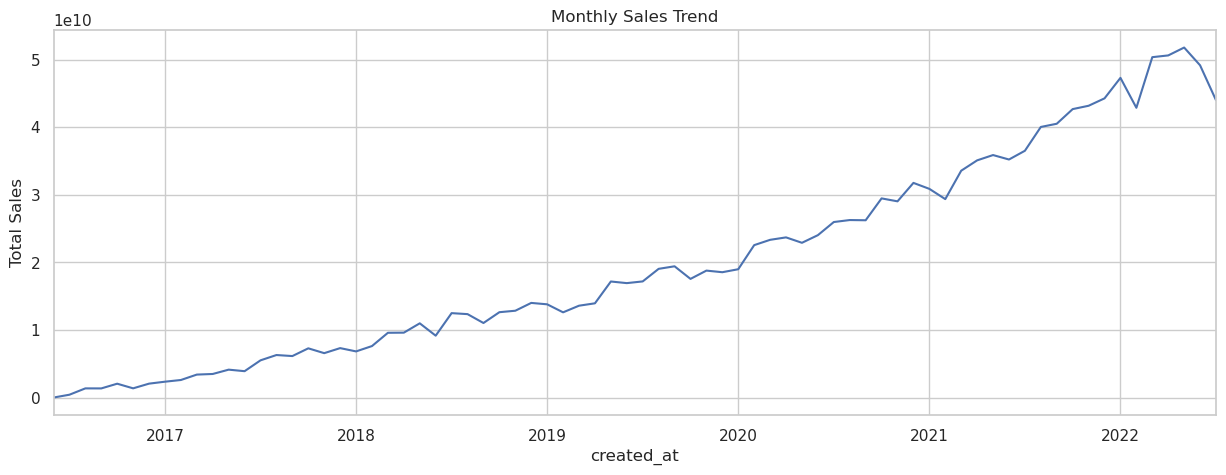

In [56]:
df_transaction_trend['created_at'] = pd.to_datetime(df_transaction_trend['created_at'])
df_transaction_trend.set_index('created_at', inplace=True)

# Monthly sales trend
plt.figure(figsize=(15, 5))
monthly_sales = df_transaction_trend['total_amount'].resample('M').sum()
monthly_sales.plot()
plt.title('Monthly Sales Trend')
plt.ylabel('Total Sales')
plt.show()


**2. Weekly trends in total sales volume**

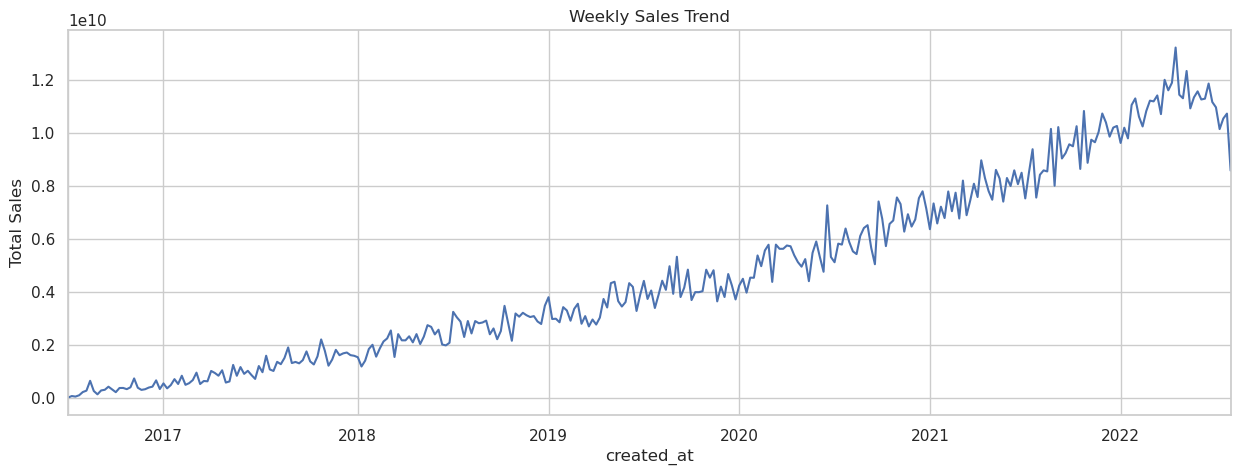

In [57]:
# Weekly sales trend (optional)
plt.figure(figsize=(15, 5))

weekly_sales = df_transaction_trend['total_amount'].resample('W').sum()
weekly_sales.plot()
plt.title('Weekly Sales Trend')
plt.ylabel('Total Sales')
plt.show()

**3. Daily trends in total sales volume**

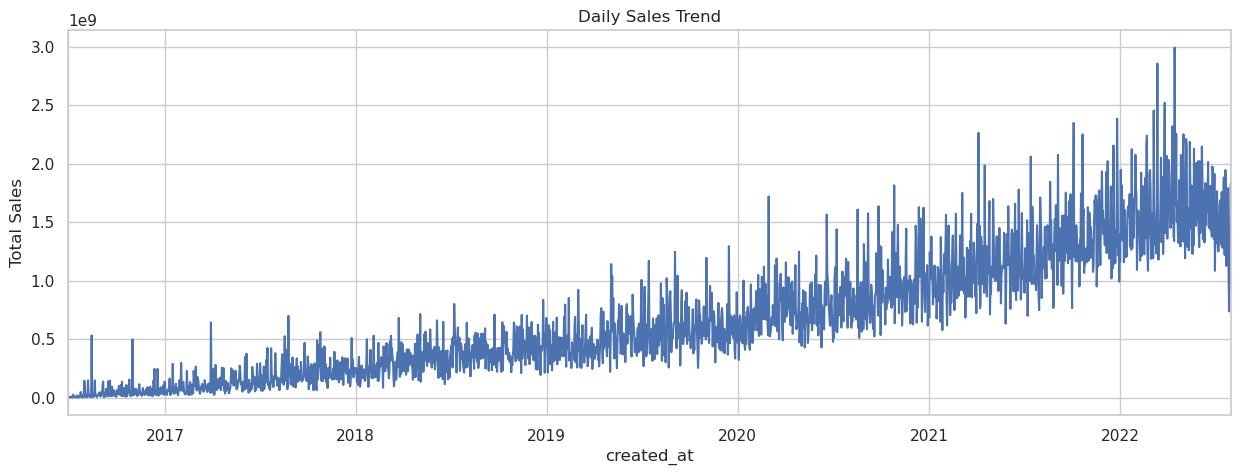

In [58]:
plt.figure(figsize=(15, 5))
daily_sales = df_transaction_trend['total_amount'].resample('D').sum()
daily_sales.plot()
plt.title('Daily Sales Trend')
plt.ylabel('Total Sales')
plt.show()

#### **_03.4.4. Apply the ARIMA model to the weekly sales forecasting problem_**

- Yếu tố xu hướng (trend) thể hiện đà tăng hoặc giảm của chuỗi trong tương lai. Chẳng hạn như lạm phát là xu hướng chung của các nền kinh tế, do đó giá cả trung bình của giỏ hàng hóa cơ sở hay còn gọi là chỉ số CPI luôn có xu hướng tăng và xu hướng tăng này đại diện cho sự mất giá của đồng tiền.
- Chúng ta xét hình `Weekly Sales Trend` Đồ thị về yếu tố xu hướng trong chuỗi thời gian của tổng doanh số

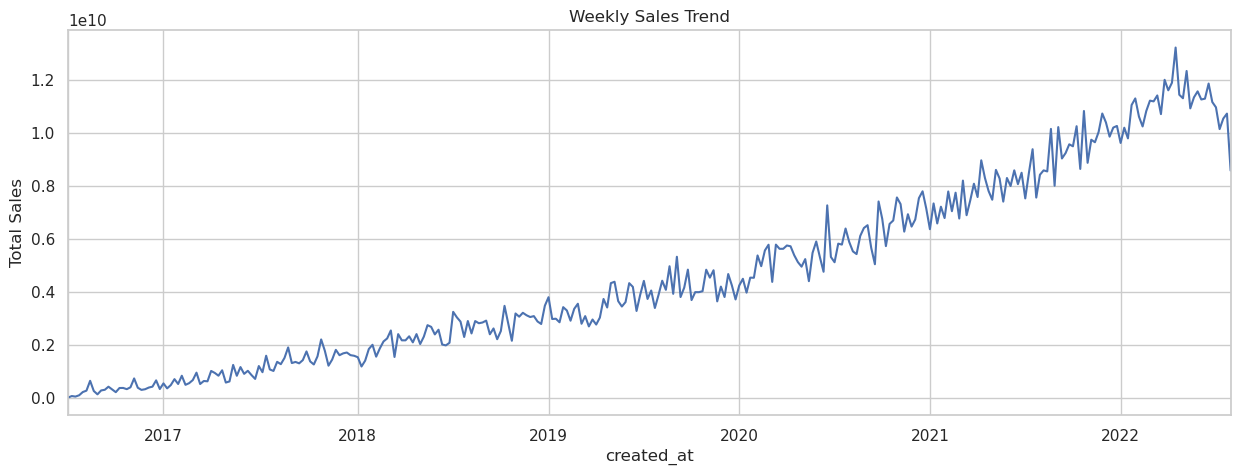

In [59]:
# Weekly sales trend (optional)
plt.figure(figsize=(15, 5))

weekly_sales = df_transaction_trend['total_amount'].resample('W').sum()
weekly_sales.plot()
plt.title('Weekly Sales Trend')
plt.ylabel('Total Sales')
plt.show()

Ta nhận thấy chuỗi có chu kì là 1 năm. Nhu cầu mua sắm trên sàn thương mại điện tử tăng vào những tháng khi bắt đầu dịch covid-19 bùng nổ, khi đó người dân ở nhà nên việc mua sắm tại nhà trở nên phổ biến hơn. Ngoài ra chúng ta có thể sử dụng một phép phân rã mùa vụ (seasonal decompose) để trích lọc ra các thành phần cấu thành nên chuỗi bao gồm: xu hướng (trend), mùa vụ (seasonal), phần dư (residual) như bên dưới:



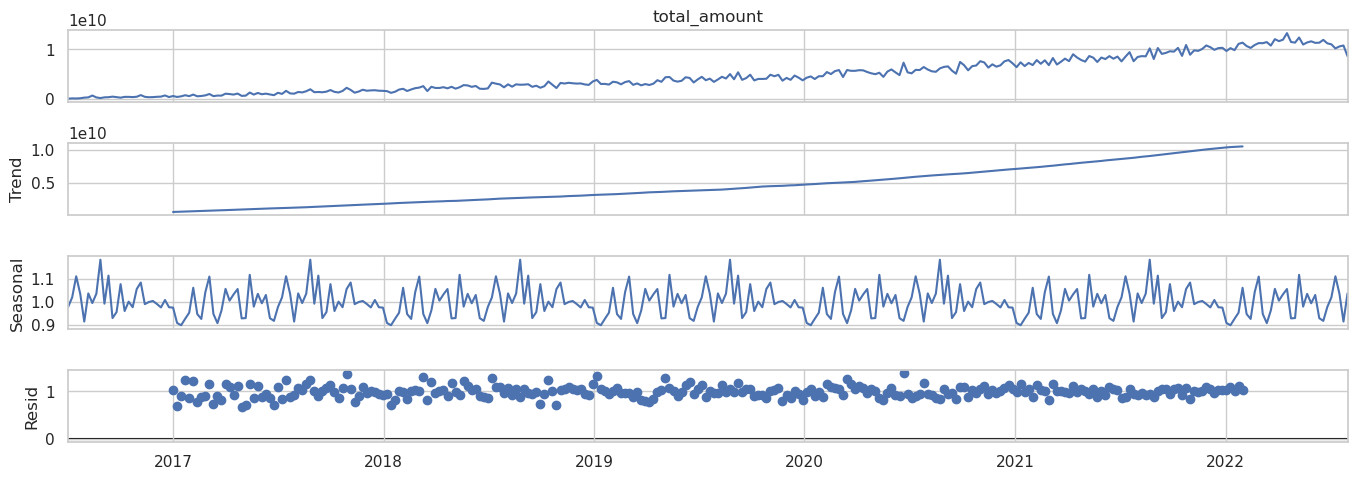

In [60]:
result = seasonal_decompose(weekly_sales, model='multiplicative')
fig = result.plot()
fig.set_size_inches(15, 5)

Như vậy các thành phần đã được tách ra khá rõ ràng như thể hiện trong biểu đồ trên. Tiếp theo ta sẽ cùng hồi qui mô hình SARIMA.



- **Phân chia tập train/test** Đầu tiên để thuận tiện cho việc kiêm định mô hình dự báo chúng ta sẽ phân chia tập train/test sao cho năm 2022 sẽ được sử dụng làm dữ liệu test và dữ liệu còn lại được sử dụng để huấn luyện mô hình.



In [61]:
train, test = weekly_sales[weekly_sales.index < '2022-01-01'], weekly_sales[weekly_sales.index >= '2022-01-01']
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (287,)
test shape:  (31,)


Chúng ta sẽ cùng kiểm tra xem các đặc tính tự tương quan và tương quan riêng phần của chuỗi mua hàng ra sao. Từ đó quyết định xem quá trình tự hồi qui và trung bình trượt của mô hình ARIMA nên nằm trong khoảng giá trị bao nhiêu và sử dụng phương pháp stepwise để tìm kiếm mô hình phù hợp nhất.

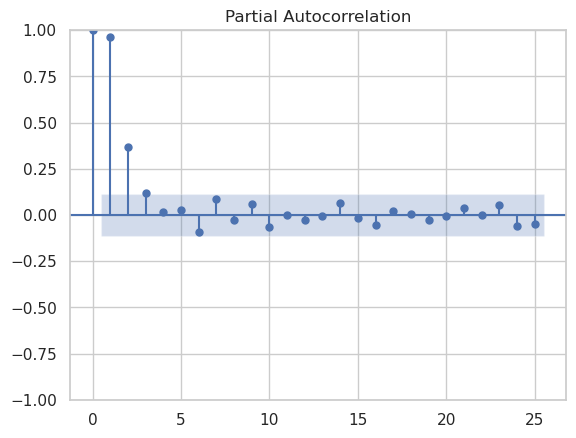

In [62]:
plot_pacf(train);

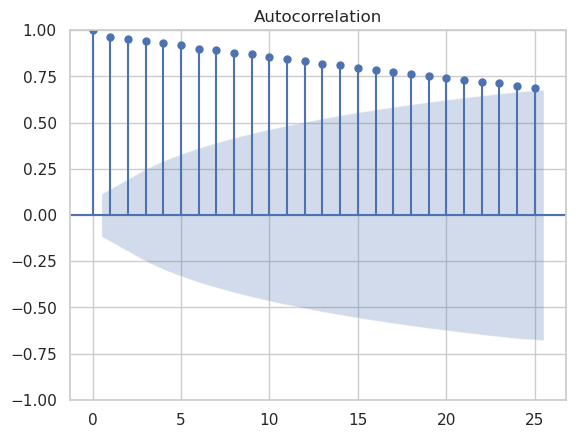

In [63]:
plot_acf(train);

Như vậy từ biểu đồ ta có thể lựa chọn bậc tự tương quan riêng phần PACF và tự tương quan ACF là các giá trị nhỏ hơn hoặc bằng 3. Do chuỗi có trend nên chúng ta sẽ lấy sai phân bậc 1 để tạo chuỗi dừng, hay nói cách khác bậc của intergration `d = 1`
. Ngoài ra chúng ta cần phải xác định thêm các bậc `(P,D,Q)`
 của yếu tố mùa vụ được trích xuất từ chuỗi ban đầu. Để mô hình hiểu được chúng ta đang hồi qui trên mô hình SARIMA thì cần thiết lập tham số seasonal=True và chu kì của mùa vụ m=12. Chiến lược stepwise sẽ tự động tìm cho ta một mô hình tốt nhất dựa trên tham số đã thiết lập.

In [64]:
model_sarima = auto_arima(train, start_p=0, start_q=0,
                           max_p=2, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=11956.349, Time=0.11 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=12069.868, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=11926.986, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=11817.812, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=11914.806, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=11818.245, Time=0.25 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=11818.294, Time=0.35 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=11847.335, Time=0.18 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=11820.238, Time=0.58 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=11817.415, Time=0.23 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=11915.108, Time=0.11 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=11817.288, Time=0.31 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=11848.327, Time=0.25 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=11819.288, Time=0.73 sec
 ARIM

Phương pháp stepwise đã giúp chúng ta tìm được mô hình SARIMA tốt nhất cho bài toán dự báo như bên dưới:



In [65]:
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  287
Model:             SARIMAX(0, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -5901.448
Date:                              Sun, 24 Dec 2023   AIC                          11812.895
Time:                                      14:03:46   BIC                          11830.961
Sample:                                  07-03-2016   HQIC                         11820.146
                                       - 12-26-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9661      0.108     -8.948      0.000      -1.178      -0.754
ma.L2          0.1189      0.110      1.082      0.279      -0.096       0.334
ar.S.L12      -0.1485      0.139     -1.072      0.284      -0.420       0.123
ma.S.L12      -0.8111      0.117     -6.946      0.000      -1.040      -0.582
sigma2      4.829e+17   1.48e-19   3.27e+36      0.000    4.83e+17    4.83e+17
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                14.08
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               6.18   Skew:                             0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.17e+51. Standard errors may be unstable.
"""

Sau khi đã tìm ra được mô hình ARIMA tốt nhất. Chúng ta sẽ dự báo cho khoảng thời gian tiếp theo. Dự báo cho chuỗi thời gian khá đặc thù và khác biệt so với các lớp mô hình dự báo khác vì giá trị time step liền trước sẽ được sử dụng để dự báo cho time step liền sau. Do đó đòi hỏi phải có một vòng lặp liên tiếp dự báo qua các bước thời gian.



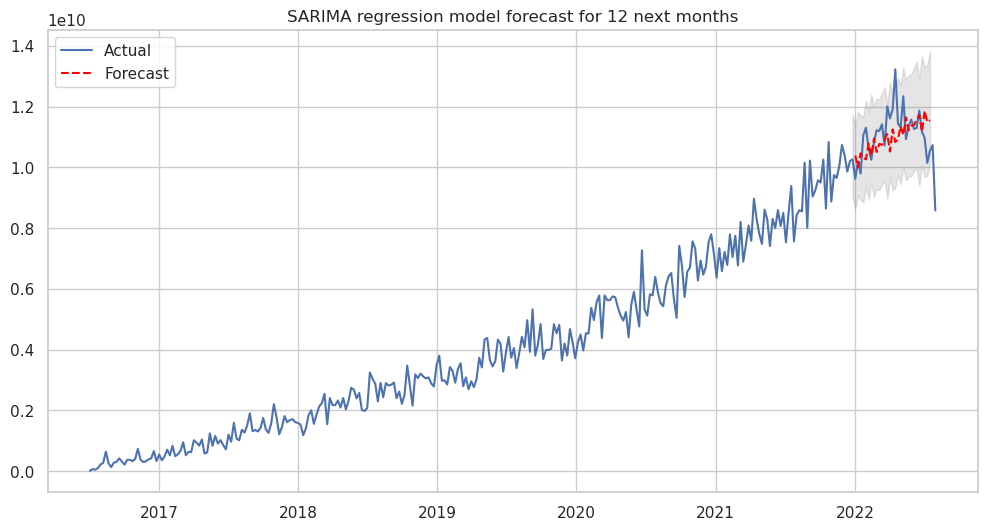

In [66]:
n_pred_perious = 30
fitted, confint = model_sarima.predict(n_periods=n_pred_perious, return_conf_int=True)
date = pd.date_range(train.index[-1], periods=n_pred_perious, freq='W')

fitted_seri = pd.Series(fitted, index=date)
lower = confint[:, 0]
upper = confint[:, 1]

plt.figure(figsize=(12, 6))
plt.plot(weekly_sales[-318:], label='Actual')
plt.plot(fitted_seri, color='red', linestyle='--', label = 'Forecast')
plt.fill_between(date,
                 lower,
                 upper,
                 color='grey', alpha=0.2)
# plt.ylim((0, 130))
plt.legend()
plt.title('SARIMA regression model forecast for 12 next months')
plt.show()

- Chúng ta có thể thấy rằng mô hình đã dự đoán được doanh thu của sàn thương mại điện tử Fashion Campus. Mặc dù ở giai đoạn cuối năm 2022 doanh thu của công ty có sụt giảm, nhưng nhìn chung từ mô hình Arima chúng ta có thể dự đoán được một phần nào đó doanh thu của công ty.
- Mô hình Arima dụ đoán kết quả chưa thể hiện được sự biến đổi mạnh của doanh thu, như đã thể hiện trong hình so sánh doanh thu theo mùa, thì chúng ta thấy dữ liệu biến động mạnh là do mùa xuân lượng người mua rất ít.


#### **_03.4.5. Profit trends over time for individual industries_**


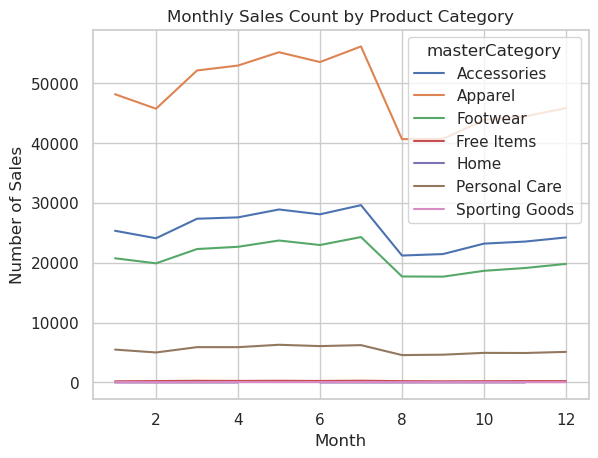

In [67]:
df_trans_prod = df_transaction[['created_at','customer_id' , 'product_id']].merge(df_product[['product_id' , 'masterCategory' , 'gender']])

df_trans_prod_create = df_trans_prod
df_trans_prod_create['created_at'] = pd.to_datetime(df_trans_prod_create['created_at'])
df_trans_prod_create.set_index('created_at', inplace=True)

monthly_product_sales = df_trans_prod_create.groupby([df_trans_prod_create.index.month, 'masterCategory']).size().unstack()
monthly_product_sales.plot()
plt.title('Monthly Sales Count by Product Category')
plt.ylabel('Number of Sales')
plt.xlabel('Month')
plt.show()

- Chúng ta có thể thấy rằng ngành hàng `Apparel` (Trang phục) luôn đạt lợi nhuận cao nhất theo thời gian.
- Tiếp theo đó là ngành hàng `Accessories` (Phụ kiện) đi theo. Chúng ta cũng dễ hiểu rằng đây là hai mặt hàng có quan hệ mật thiết với nhau.

## **_04. Reflection:_**